In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('C:/Users/Sindhu/AML Project/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('C:/Users/Sindhu/AML Project/combined_data', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 25591 , Total Headers 112120


In [3]:
#To loop through images files and fill the column
image_present = []

for i in all_image_paths.keys():
    image_present.append(i)


new_df= all_xray_df[all_xray_df['Image Index'].isin(image_present)]

In [4]:
#all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df = new_df
all_xray_df.shape

(25591, 12)

## Make Sure GPU is being used

In [1]:
# Add the path to the dataset.
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
#all_xray_df.sample(3)

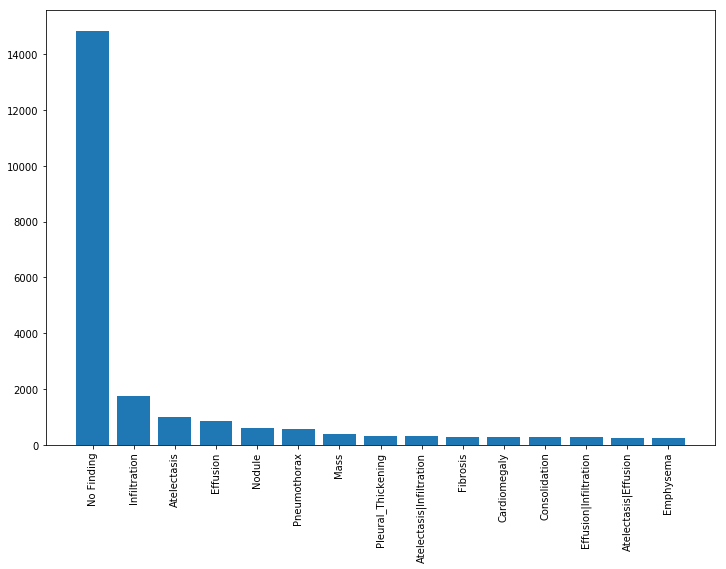

In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [7]:
# Reducing no findings
first_half = all_xray_df[0:18000]
second_half = all_xray_df[18000:]

all_xray_trial1 = first_half[first_half['Finding Labels']!= 'No Finding']
all_xray_trial2 = second_half
frames = [all_xray_trial1, all_xray_trial2]
all_xray_df = pd.concat(frames)
len(all_xray_df)

15164

In [8]:
# We will remove No finding labels as there are more than 50% No finding cases that can make data imbalanced
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5220,00001385_019.png,Edema|Infiltration,19,1385,63,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33560,00008802_009.png,Infiltration,9,8802,52,F,PA,2470,2589,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14071,00003643_003.png,Fibrosis|Pleural_Thickening,3,3643,68,F,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (6) [('Atelectasis', 2485), ('Effusion', 2484), ('Infiltration', 3684), ('No Finding', 4414), ('Nodule', 1272), ('Pneumothorax', 1148)]


In [10]:
# Split the lables by '|' and check how many labels are present for each image.
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(len(sample_weights), weights=sample_weights)


In [11]:
len(sample_weights)

15164

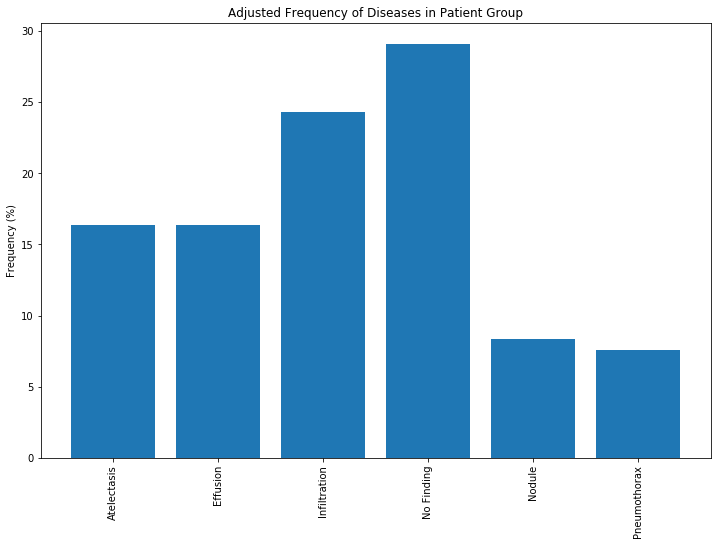

In [12]:
# Adjusted frequency of disease grps
label_counts = 100*np.mean(all_xray_df[all_labels].values,0) # mean number of labels for each image
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Data for Modeling

In [13]:
# Prepare training data
# Create target vector
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [14]:
# data split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2019,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 11373 test 3791


# Create Generator

In [16]:
# Loading and transforming images
# ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05,
                               rescale = 1.0/255.0,
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [17]:
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

## To make sure that the current GPU memory utilization is 0

In [3]:
IMG_SIZE = (255, 255)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

train_gen = datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col = 'path',
y_col = 'newLabel', class_mode = 'categorical',
classes = all_labels, target_size = IMG_SIZE, color_mode = 'rgb',
batch_size = 256) 

test_gen = datagen.flow_from_dataframe(dataframe= test_df, directory=None, x_col = 'path',
y_col = 'newLabel', class_mode = 'categorical',
classes = all_labels, target_size = IMG_SIZE, color_mode = 'rgb',
batch_size = 256) # we can use much larger batches for evaluation

test_X, test_Y = next(datagen.flow_from_dataframe(dataframe=test_df, 
directory=None,
x_col = 'path', y_col = 'newLabel', 
class_mode = 'categorical', classes = all_labels,
target_size = IMG_SIZE,
color_mode = 'rgb', batch_size = 512))

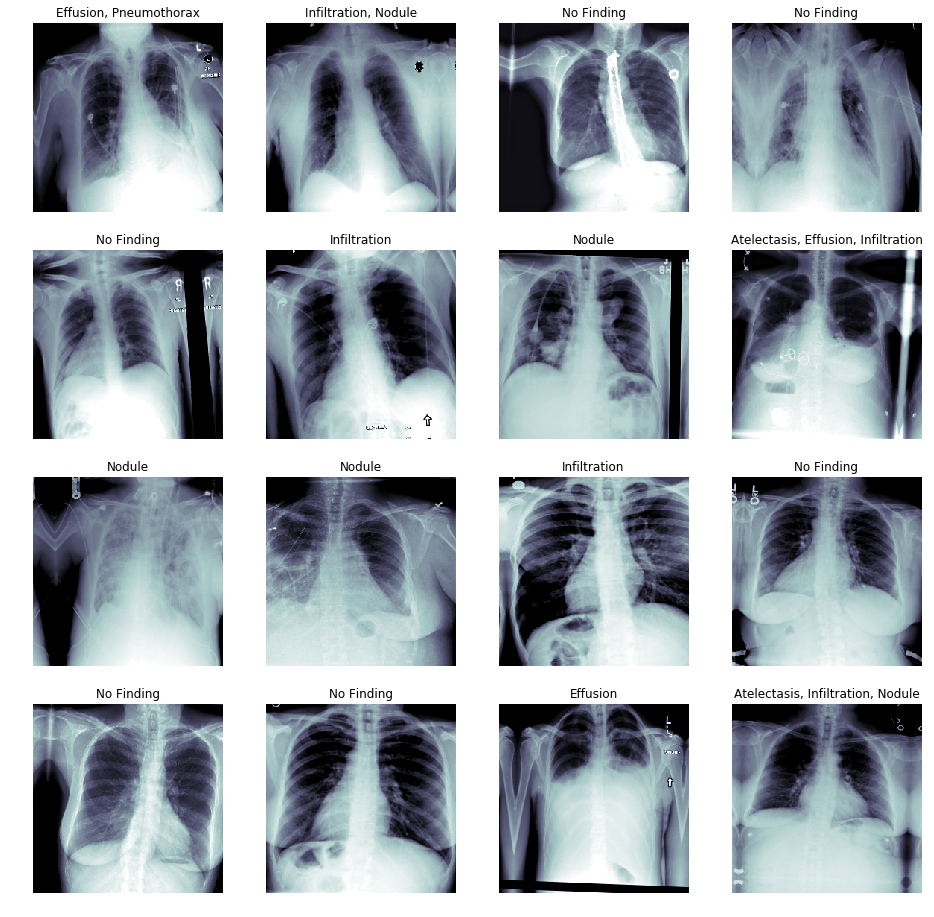

In [19]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [4]:
# Evaluation metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)
callbacks_list = [checkpoint, early]

class_weights = {0: 1.0787931408725853,
 1: 5.166320166320166,
 2: 3.7298311444652907,
 3: 6.675621222296844,
 4: 1.4675919090506422,
 5: 7.161383285302594,
 6: 10.22633744855967,
 7: 79.52,
 8: 1.0,
 9: 3.4694589877835953,
 10: 3.202319587628866,
 11: 9.1109074243813,
 12: 38.23076923076923,
 13: 5.6477272727272725}

res = ResNet50(input_shape=t_x.shape[1:], weights='imagenet', include_top=False)
# don't train existing weights
for layer in res.layers:
  layer.trainable = False
x = Flatten()(res.output)
#x = Dense(1000, activation='relu')(x)
prediction = Dense(len(all_labels), activation='relu')(x)
# create a model object
model_resnet = Model(inputs=res.input, outputs=prediction)
model_resnet.summary()

In [22]:
res = ResNet50(input_shape=t_x.shape[1:], weights='imagenet', include_top=False)
# don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [23]:
x = Flatten()(res.output)
#x = Dense(1000, activation='relu')(x)
prediction = Dense(len(all_labels), activation='sigmoid')(x)

# create a model object
model_resnet = Model(inputs=res.input, outputs=prediction)
model_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 255, 255, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 261, 261, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
model_resnet.compile(
  loss='binary_crossentropy',
  optimizer='nadam',
  metrics=['binary_accuracy', 'mae',f1_m,'categorical_accuracy', recall_m]
)

In [25]:
r = model_resnet.fit_generator(
  train_gen,
  validation_data=(test_X, test_Y),
  epochs=10,
  steps_per_epoch= 10,
  callbacks = callbacks_list,
  validation_steps= 10000 / 256,
  class_weight = class_weights
)


Epoch 1/10
10/10 [==============================] - 1505s 150s/step - loss: 12.1668 - binary_accuracy: 0.7693 - mean_absolute_error: 0.2309 - f1_m: 0.0625 - categorical_accuracy: 0.2129 - recall_m: 0.0758 - val_loss: 3.2423 - val_binary_accuracy: 0.7988 - val_mean_absolute_error: 0.2012 - val_f1_m: 0.0000e+00 - val_categorical_accuracy: 0.1875 - val_recall_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 3.24232, saving model to xray_class_weights.best.hdf5
Epoch 2/10
10/10 [==============================] - 1358s 136s/step - loss: 12.9766 - binary_accuracy: 0.7954 - mean_absolute_error: 0.2047 - f1_m: 0.0741 - categorical_accuracy: 0.2336 - recall_m: 0.0548 - val_loss: 2.6128 - val_binary_accuracy: 0.7910 - val_mean_absolute_error: 0.2111 - val_f1_m: 0.0723 - val_categorical_accuracy: 0.3359 - val_recall_m: 0.0405

Epoch 00002: val_loss improved from 3.24232 to 2.61284, saving model to xray_class_weights.best.hdf5
Epoch 3/10
10/10 [==============================] - 1409s 141s

In [26]:
# Save the model
model_resnet.save('model_resnet.h5', overwrite = False)

[WARNING] model_resnet.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [53]:
from keras.models import load_model
# load model
model = load_model('model_resnet.h5')
# summarize model.
model.summary()

# evaluate the model
score = model.evaluate(test_X, test_Y, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

END OF CODE


In [28]:
model_resnet.evaluate(test_X,test_Y)

512/512 [==============================] - 232s 453ms/step


[3.9674003422260284,
 0.747395858168602,
 0.25265756249427795,
 0.3119195345789194,
 0.34375,
 0.2860315991565585]

In [29]:
pred_Y = model_resnet.predict(test_X, batch_size = 32, verbose = True)

512/512 [==============================] - 268s 523ms/step


In [40]:
#for first category

test_Y_1 = test_Y[:,0]
pred_Y_1 = pred_Y[:,0]

pred_Y_trial =[]


for i in range(len(pred_Y_1)):
    if pred_Y_1[i] >= 0.4:
        pred_Y_trial.append(1)
    else:
        pred_Y_trial.append(0)
        
        
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_Y_1, pred_Y_trial)
print(confusion_matrix)


classification_report = metrics.classification_report(test_Y_1, pred_Y_trial)
print(classification_report)
    

[[419   0]
 [ 93   0]]
             precision    recall  f1-score   support

        0.0       0.82      1.00      0.90       419
        1.0       0.00      0.00      0.00        93

avg / total       0.67      0.82      0.74       512



In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
# Show images and associated predictions.

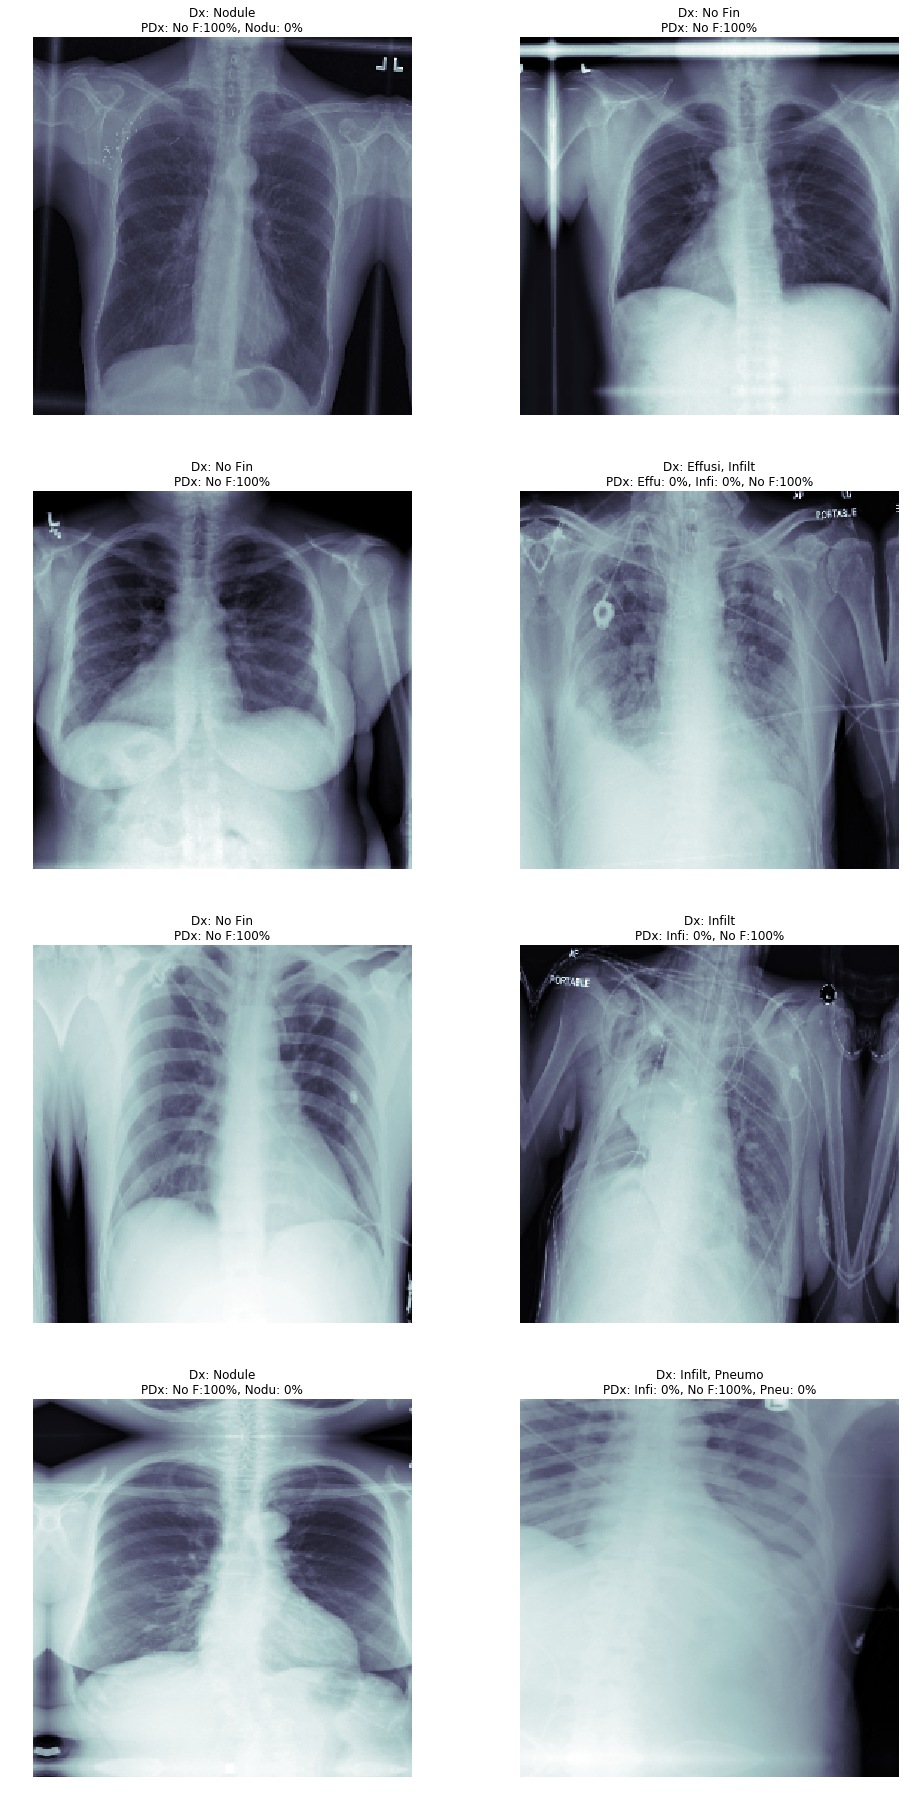

In [54]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_resnetimg_predictions.png')

In [ ]:
resnet_history = model_resnet.fit_generator(
                                  train_gen,
  validation_data=(test_X, test_Y),
  epochs=10,
  steps_per_epoch= 10,
  callbacks = callbacks_list,
  validation_steps= 10000 / 256,
  class_weight = class_weights)

In [ ]:
print(resnet_history.history.keys())
#str(history.history['loss',])
plt.subplot(211)  
#print(inception_history.history)
#print(callbacks_list)
plt.plot(resnet_history.history['val_loss'])  
plt.plot(resnet_history.history['loss'])  
#plt.plot(inception_history.history['binary_accuracy'])  
#plt.titleplt.legend(['train', 'test'], loc='upper left') ('model accuracy')  
#plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
#plt.subplot(221)
plt.plot(resnet_history.history['val_acc'])  
plt.plot(resnet_history.history['acc'])  
#plt.plot(inception_history.history['binary_accuracy'])  
#plt.title('model accuracy')  
#plt.ylabel('accuracy')  
plt.xlabel('epoch')  


In [ ]:
from sklearn import metrics
pred_class = np.round(pred_Y,1)
pred_class = np.ceil(pred_class)
classification_metrics = metrics.classification_report(test_Y, pred_class, target_names = all_labels)
print(classification_metrics)

In [ ]:
counts_labels = [('Atelectasis', 2485), ('Effusion', 2484), ('Infiltration', 3684),('No Finding', 4414), ('Nodule', 1272), ('Pneumothorax', 1148)]
print(counts_labels)